## Smart Air Quality Monitoring System - IoT and ML Project

### Name - Rishabh Pathak , Narendra Iyer
### Group - Group 8

### **1. Introduction**
This project aims to analyze and predict air quality using an IoT-based Smart Urban Air Quality Monitoring System. The dataset is sourced from the UCI Machine Learning Repository and includes measurements of air pollutants such as CO, benzene, and NOx.
----

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2)  and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
----


### **2. Importing Required Libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

### **3. Loading the Dataset**

In [7]:
data = pd.read_excel('AirQualityUCI.xlsx')

### **4. Display Basic Information About the Dataset**

In [8]:
print("Dataset Info:")
print(data.info())
print("\nFirst 5 Rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: date

### **5. Exploratory Data Analysis (EDA)**
#### **5.1 Checking for Missing Values**

In [9]:
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


#### **5.2 Visualizing Data Distributions**

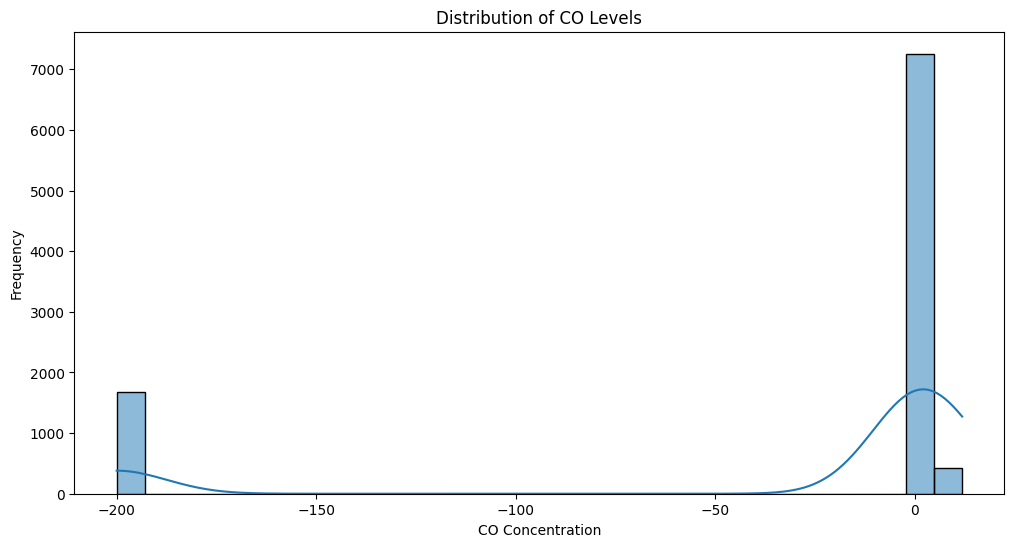

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(data['CO(GT)'].dropna(), kde=True, bins=30)
plt.title("Distribution of CO Levels")
plt.xlabel("CO Concentration")
plt.ylabel("Frequency")
plt.show()

#### **5.3 Correlation Matrix**

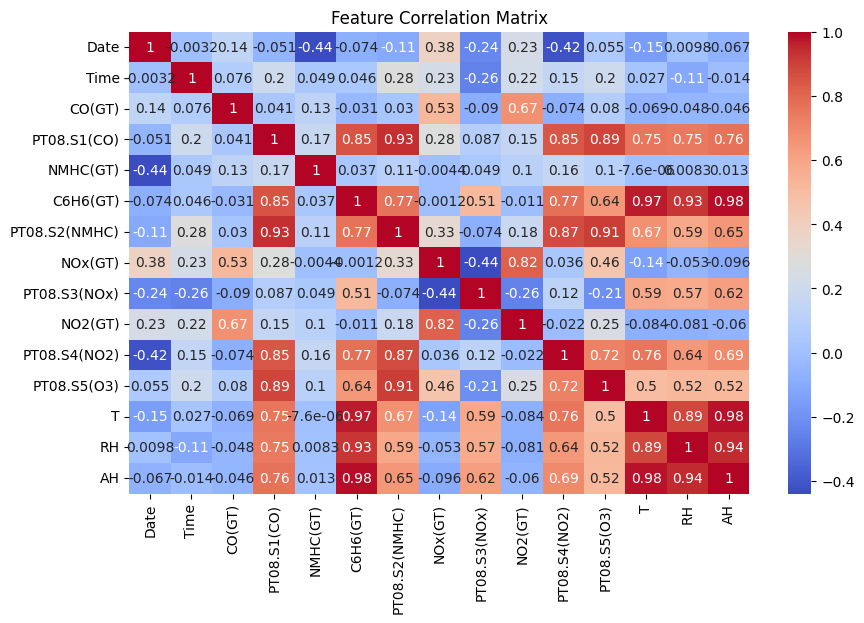

In [13]:
data["Time"] = pd.to_datetime(data["Time"], format="%H:%M:%S").dt.hour * 3600 + \
               pd.to_datetime(data["Time"], format="%H:%M:%S").dt.minute * 60 + \
               pd.to_datetime(data["Time"], format="%H:%M:%S").dt.second
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

### **6. Data Cleaning and Preprocessing**

In [17]:
# Replace -200 with NaN (handling missing values)
data = data.replace(-200, np.nan)
data.dropna(inplace=True)

# Convert "Time" from seconds to HH:MM:SS format
data['Time'] = pd.to_timedelta(data['Time'].astype(int), unit='s')

# Convert timedelta to formatted time strings (HH:MM:SS)
data['Time'] = data['Time'].dt.total_seconds().astype(int)
data['Time'] = data['Time'] // 3600 % 24
data['Minutes'] = (data['Time'] % 3600) // 60
data['Seconds'] = data['Time'] % 60

# Format "Time" as HH:MM:SS
data['Time'] = data['Time'].astype(str).str.zfill(2) + ":" + \
               data['Minutes'].astype(str).str.zfill(2) + ":" + \
               data['Seconds'].astype(str).str.zfill(2)

# Combine "Date" and "Time" into a single Datetime column
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'])

# Set "Datetime" as index
data.set_index('Datetime', inplace=True)

# Drop original "Date", "Time", "Minutes", and "Seconds" columns
data.drop(columns=['Date', 'Time', 'Minutes', 'Seconds'], inplace=True)

### **7. Selecting Relevant Features for ML**

In [18]:
target_variable = 'CO(GT)'
feature_columns = ['PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

### **8. Splitting Data into Training and Testing Sets**

In [19]:
X = data[feature_columns]
y = data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **9. Feature Scaling**

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **10. Machine Learning Model - Time Series Prediction (Linear Regression)**

In [21]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

#### **10.1 Model Evaluation - Linear Regression**

In [23]:
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear Regression MAE: 0.1778000968766178
Linear Regression RMSE: 0.2408800242208912


### **11. Deep Learning Model - LSTM for Time Series Forecasting**

In [24]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

C:\Users\rpris\PycharmProjects\TestProject\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **11.1 Compiling and Training the LSTM Model**

In [25]:
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.4039 - val_loss: 3.8504
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2209 - val_loss: 2.0386
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3198 - val_loss: 0.6249
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4408 - val_loss: 0.2130
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2613 - val_loss: 0.1263
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1836 - val_loss: 0.0906
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1703 - val_loss: 0.0879
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1830 - val_loss: 0.0904
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1925 - val_loss: 0.1174
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2191 - val_loss: 0.1003


#### **11.2 Model Evaluation - LSTM**

In [26]:
y_pred_lstm = lstm_model.predict(X_test_lstm)
print("LSTM MAE:", mean_absolute_error(y_test, y_pred_lstm))
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lstm)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
LSTM MAE: 0.23073229279862834
LSTM RMSE: 0.3167791708210708


### **12. Saving the Models**

#### **11.3 Visualizing LSTM Predictions**

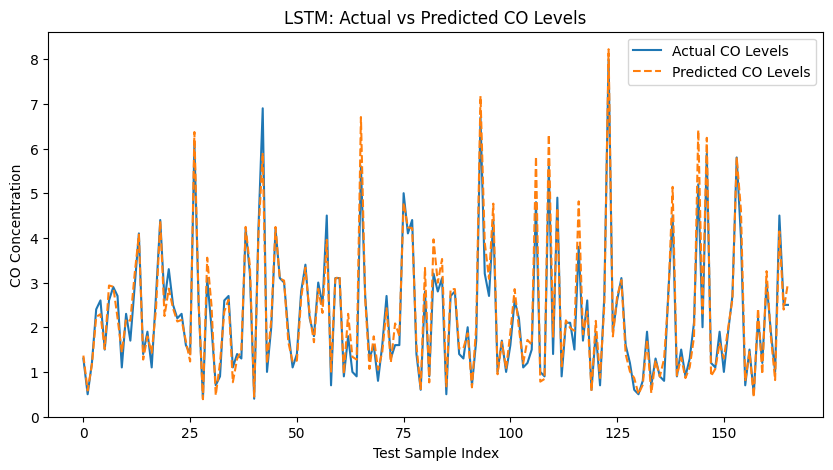

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual CO Levels')
plt.plot(y_pred_lstm, label='Predicted CO Levels', linestyle='dashed')
plt.legend()
plt.title("LSTM: Actual vs Predicted CO Levels")
plt.xlabel("Test Sample Index")
plt.ylabel("CO Concentration")
plt.show()

### **12. Saving the Models**

In [29]:
import joblib
joblib.dump(lr_model, 'linear_regression_model.pkl')
lstm_model.save('lstm_model.h5')

print("Models saved successfully.")

Models saved successfully.
